# Inference kernel for [[Torch XLA] Melanoma Crazy Fast](https://www.kaggle.com/shonenkov/torch-xla-melanoma-crazy-fast)

Hi everyone!

This kernel is inference part for tpu training using torch/xla. 

Some of you have asked questions about stable roc_auc on validation and LB. It is normal, private, public and cv datasets have different distributions! Nobody can't guarantee private stage without shake up. You should understand it and use own strategy. If you think that public LB score is correct, it is your strategy. My strategy is best local cross-validation scores. In the final submission I won't choose high public score with blind blend, I will choose my best OOF prediction for my models.

I wish all of us good luck on private stage!

# Main Idea

Use some techniques for more stable prediction:

- several checkpoints from one fold
- ensemble of 5 folds
- no blend of public solutions

In [1]:
!pip install -q efficientnet_pytorch > /dev/null
!pip install --no-deps timm > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from glob import glob
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import albumentations as A
import scipy as sp
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import ToTensor
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn import functional as F
from glob import glob
import sklearn
from torch import nn
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
DATA_PATH = '../input/melanoma-merged-external-data-512x512-jpeg'
TEST_ROOT_PATH = f'{DATA_PATH}/512x512-test/512x512-test'

# DATA_PATH = '../input/jpeg-melanoma-512x512'
# TEST_ROOT_PATH = f'{DATA_PATH}/test'

In [4]:
from torchvision import transforms

def get_valid_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (256,256), cv2.INTER_AREA)

        if self.transforms:
            image = self.transforms(image)
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
df_test = pd.read_csv(f'../input/siim-isic-melanoma-classification/test.csv', index_col='image_name')

test_dataset = DatasetRetriever(
    image_ids=df_test.index.values,
    transforms=get_valid_transforms(),
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32,
    num_workers=10,
    shuffle=False,
    sampler=SequentialSampler(test_dataset),
    pin_memory=False,
    drop_last=False,
)

# Net

In [6]:
import timm

def get_net():
    net = timm.create_model('resnext50d_32x4d', pretrained=False)
    net.fc = nn.Linear(in_features=net.fc.in_features, out_features=2, bias=True)
    return net

net = get_net().cuda()

# Inference

In [7]:
def run_inference(net, test_loader):
    result = {'image_name': [], 'target': []}
    for images, image_names in tqdm(test_loader, total=len(test_loader)):
        with torch.no_grad():
            images = images.cuda().float()
            outputs = net(images)
            y_pred = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]
        result['image_name'].extend(image_names)
        result['target'].extend(y_pred)
    return pd.DataFrame(result).set_index('image_name')

In [8]:
submissions = []
checkpoint_paths = sorted(glob('../input/isic-resnext50d-32x4d-public-checkpoints/*.bin'))
for checkpoint_path in checkpoint_paths:
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint);
    net.eval();
    submission = run_inference(net, test_loader)
    submissions.append(submission)

100%|██████████| 344/344 [01:07<00:00,  5.13it/s]


# Rankdata
Here I would like to say very good thanks [Dmytro Danevskyi @ddanevskyi](https://www.kaggle.com/ddanevskyi) for [this topic about non-calibrated predictions](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/156064). It really helped me, I recommend to use this technique for ensemble.

In [9]:
from scipy.stats import rankdata

result_submission = submissions[0].copy()
result_submission['target'] = 0
for submission in submissions:
    result_submission['target'] += rankdata(submission['target']) / len(submissions)

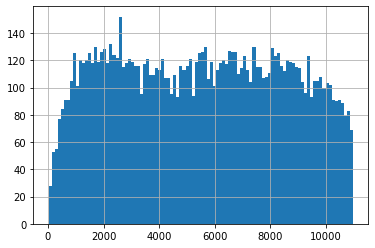

In [10]:
result_submission.to_csv('submission.csv')
result_submission['target'].hist(bins=100);

# OOF Evaluation

In [11]:
df_folds = pd.read_csv('../input/melanoma-merged-external-data-512x512-jpeg/folds_13062020.csv', index_col='image_id')

In [12]:
TRAIN_ROOT_PATH = f'{DATA_PATH}/512x512-dataset-melanoma/512x512-dataset-melanoma'
# TRAIN_ROOT_PATH = f'{DATA_PATH}/train'

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (256, 256), cv2.INTER_AREA)
        label = self.labels[index]     
        if self.transforms:
            image = self.transforms(image)
        return image, label, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)

In [13]:
oof_predictions = []

for checkpoint_paths in [
    sorted(glob('../input/isic-resnext50d-32x4d-public-checkpoints/*-bestauc-*.bin')),
    sorted(glob('../input/isic-resnext50d-32x4d-public-checkpoints/*-bestloss-*.bin')),
]:
    result = {'target': [], 'pred': [], 'image_name': []}
    for fold_number, checkpoint_path in tqdm(enumerate(checkpoint_paths), total=len(checkpoint_paths)):
        df_val = df_folds[(df_folds['fold'] == fold_number) & (df_folds['source'] == 'ISIC20')]

        validation_dataset = DatasetRetriever(
            image_ids=df_val.index.values,
            labels=df_val.target.values,
            transforms=get_valid_transforms(),
        )

        validation_loader = torch.utils.data.DataLoader(
            validation_dataset, 
            batch_size=32,
            num_workers=10,
            shuffle=False,
            sampler=SequentialSampler(validation_dataset),
            pin_memory=False,
            drop_last=False,
        )

        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint);
        net.eval();

        for step, (images, targets, image_names) in enumerate(validation_loader):
            with torch.no_grad():
                images = images.cuda().float()
                outputs = net(images)
                y_pred = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]
            result['target'].extend(targets.numpy())
            result['pred'].extend(y_pred)
            result['image_name'].extend(image_names)
            
    oof_predictions.append(pd.DataFrame(result).set_index('image_name'))

100%|██████████| 5/5 [03:19<00:00, 39.93s/it]


In [14]:
result_oof = oof_predictions[0].copy()
result_oof['pred'] = 0
for oof_prediction in oof_predictions:
    result_oof['pred'] += rankdata(oof_prediction['pred']) / len(oof_predictions)

print('-'*30)
print(f"[OOF RocAuc]: {sklearn.metrics.roc_auc_score(result_oof['target'], result_oof['pred']):.3f}")
print(f"[OOF AP]: {sklearn.metrics.average_precision_score(result_oof['target'], result_oof['pred']):.3f}")
print('-'*30)

------------------------------
[OOF RocAuc]: 0.962
[OOF AP]: 0.460
------------------------------


# Thank you for reading my kernel!

In [15]:
print("finish")

finish
